# Loading and Reviewing Prediction Results from the Three Models

In [2]:
import datetime as dt

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

import seaborn as sns

from scipy.stats import norm, ranksums, mannwhitneyu, shapiro, probplot, ttest_ind, pointbiserialr, spearmanr, pearsonr,\
chi2_contingency

from sklearn.metrics import precision_recall_curve, auc, make_scorer, average_precision_score, accuracy_score,\
recall_score, precision_score, f1_score, roc_curve, balanced_accuracy_score, roc_auc_score, classification_report,\
confusion_matrix, brier_score_loss

from sklearn.metrics.cluster import contingency_matrix

from statsmodels.stats.contingency_tables import mcnemar

In [3]:
#Global prameters
#Random state:
rs = 0

In [4]:
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 200

# Import prediction files

In [5]:
%cd "C:\Users\Alex\Desktop\Ryerson - Data Science\Spring 2020\MRP Course\FromPandas"

C:\Users\Alex\Desktop\Ryerson - Data Science\Spring 2020\MRP Course\FromPandas


In [6]:
dfFinal = pd.read_pickle('dfFinal.pkl')

In [7]:
resultsLR = pd.read_csv('results_LR3.csv',index_col=False)

In [8]:
resultsRF = pd.read_csv('results_RF2.csv')

In [9]:
resultsNN = pd.read_csv('results_NN_New.csv')

# Train/Test Splits

In [10]:
#Locations of 36 months training and testing data.
train36 = ((dfFinal.term_numeric==36) & (dfFinal.issue_d <= dt.datetime(year=2015, month =12, day=31)))
test36 = ((dfFinal.term_numeric==36) & (dfFinal.issue_d > dt.datetime(year=2015, month =12, day=31)))

In [11]:
#Locations of 60 months training and testing data.
train60 = ((dfFinal.term_numeric==60) & (dfFinal.issue_d <= dt.datetime(year = 2014, month = 6, day = 30)))
test60 = ((dfFinal.term_numeric==60) & (dfFinal.issue_d > dt.datetime(year = 2014, month = 6, day = 30)))

In [12]:
#Count of each type of loan based on term.
count36 = (dfFinal.term_numeric==36).sum()
count60 = (dfFinal.term_numeric==60).sum()

In [13]:
trainAll = (train36 | train60)
testAll = (test36 | test60)

In [14]:
trainTest36 = pd.Series([train36.sum()/count36, test36.sum()/count36], name = '36 Months')
trainTest60 = pd.Series([train60.sum()/count60, test60.sum()/count60], name = '60 Months')
trainTestAll = pd.Series([trainAll.sum() / dfFinal.shape[0], testAll.sum()/dfFinal.shape[0]], name = 'All Data')
df = (pd.DataFrame([trainTest36, trainTest60, trainTestAll]).T*100).round(1)
df.index = ['Train %', 'Test %']
df.T

,Train %,Test %
36 Months,65.6,34.4
60 Months,66.7,33.3
All Data,65.8,34.2


# Insert Predictions into Full DF

In [15]:
#Preview of prediction dataframe.
resultsLR.head()

,id,true_class,predict_class_LR,prob_LR
0,73713571,0,0,0.377908
1,75051478,0,0,0.450985
2,75092979,0,0,0.360520
3,75123593,0,0,0.223180
4,75358919,0,0,0.393617


In [16]:
#Merge LR results
testLoans = dfFinal[testAll].merge(resultsLR, how='left', on = 'id')

In [17]:
#Merge RF result.
keepColumns = resultsRF.columns[resultsRF.columns!='true_class']
testLoans = testLoans.merge(resultsRF[keepColumns], how='left', on = 'id')

In [18]:
#Merge NN results.
keepColumns = resultsNN.columns[resultsNN.columns!='true_class']
testLoans = testLoans.merge(resultsNN[keepColumns], how='left', on = 'id')

In [19]:
#Preview the complete dataframe with predictions.
testLoans.head()

,issue_d,earliest_cr_line,id,loan_status,fully_paid,charged_off,term_numeric,Loan_Loss,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,term,grade,sub_grade,application_type,purpose,issue_d_month,issue_d_year,loan_amnt,int_rate,installment,emp_length,home_ownership,verification_status,earliest_cr_line_month,earliest_cr_line_year,annual_inc,open_acc,total_acc,tot_cur_bal,mort_acc,dti,fico_range_low,fico_range_high,credit_hist_months,tot_hi_cred_lim,inq_last_6mths,mths_since_recent_inq,pub_rec,mths_since_last_record,acc_now_delinq,delinq_amnt,mths_since_last_delinq,delinq_2yrs,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,revol_bal,total_rev_hi_lim,num_rev_tl_bal_gt_0,mths_since_recent_bc,bc_util,percent_bc_gt_75,bc_open_to_buy,total_bc_limit,num_tl_op_past_12m,acc_open_past_24mths,mo_sin_rcnt_tl,avg_cur_bal,fico,true_class,predict_class_LR,prob_LR,predict_class_RF,prob_RF,Unnamed: 0,predict_class_NN,prob_NN
0,2016-03-01,1999-02-01,73713571,Fully Paid,1,0,36,0.0,10000.0,1853.47,0.0,0.0,0.0,36 months,B,B5,Individual,debt_consolidation,3,2016,10000,11.47,329.62,Missing,MORTGAGE,Verified,2,1999,7.031600,10,35,498232.0,5.0,8.67,715,719,207,518995.0,1.0,4.0,0,NaN,0,0,63.0,0,3.0,19.0,137.0,1755,4000.0,3.0,19.0,44.5,0.0,1887.0,2700.0,6.0,9.0,3.0,49823.0,717.0,0,0,0.377908,0,0.376075,0,0,0.316724
1,2016-03-01,1988-08-01,75051478,Fully Paid,1,0,36,0.0,10000.0,2113.59,0.0,0.0,0.0,36 months,C,C2,Individual,credit_card,3,2016,10000,12.99,336.90,6 years,RENT,Source Verified,8,1988,2.600000,10,19,20302.0,0.0,33.19,715,719,335,38096.0,1.0,3.0,1,94.0,0,0,32.0,0,6.0,3.0,70.0,7630,20000.0,6.0,3.0,40.7,33.3,4742.0,8000.0,1.0,1.0,3.0,2256.0,717.0,0,0,0.450985,0,0.483233,1,0,0.451666
2,2016-03-01,2004-10-01,75092979,Fully Paid,1,0,36,0.0,16550.0,2658.69,0.0,0.0,0.0,36 months,C,C4,Individual,debt_consolidation,3,2016,16550,14.46,569.35,4 years,MORTGAGE,Source Verified,10,2004,3.311625,5,5,19705.0,0.0,19.25,725,729,138,29623.0,0.0,NaN,0,NaN,0,0,NaN,0,3.0,43.0,137.0,16169,20400.0,3.0,43.0,79.3,66.7,4231.0,20400.0,0.0,0.0,29.0,3941.0,727.0,0,0,0.360520,0,0.410791,2,0,0.331450
3,2016-03-01,1989-04-01,75123593,Fully Paid,1,0,36,0.0,8000.0,359.86,0.0,0.0,0.0,36 months,A,A1,Individual,vacation,3,2016,8000,5.32,240.92,10+ years,RENT,Source Verified,4,1989,8.000000,14,27,35291.0,0.0,20.00,750,754,327,77825.0,0.0,12.0,0,NaN,0,0,NaN,0,10.0,5.0,323.0,11101,43000.0,10.0,5.0,31.4,28.6,22696.0,33100.0,3.0,5.0,5.0,2521.0,752.0,0,0,0.223180,0,0.155637,3,0,0.201290
4,2016-03-01,2007-01-01,75358919,Fully Paid,1,0,36,0.0,5000.0,870.97,0.0,0.0,0.0,36 months,B,B4,Individual,debt_consolidation,3,2016,5000,10.75,163.11,10+ years,RENT,Source Verified,1,2007,2.566200,6,14,24756.0,0.0,26.52,750,754,111,37192.0,0.0,NaN,0,NaN,0,0,NaN,0,2.0,14.0,77.0,6692,16600.0,2.0,NaN,NaN,NaN,NaN,0.0,3.0,7.0,5.0,4126.0,752.0,0,0,0.393617,0,0.409393,4,0,0.366966


# Overall Analysis

In [20]:
#Total Loan Loss
lostPrincipleTotal = testLoans.Loan_Loss.sum()
lostPrincipleTotal

495659999.9713575

In [21]:
#Total received interest.
recIntTotal = testLoans.total_rec_int.sum()
recIntTotal

854474874.1299999

In [24]:
#Lost principal as a percentage of total interest.
lostPrincipleTotal/recIntTotal*100

58.00755703624677

In [25]:
intGoodLoansTotal = testLoans[testLoans.charged_off==0].total_rec_int.sum()

# Number of predicted bad loans from each model.

In [26]:
testLoans.predict_class_LR.sum()

96056

In [27]:
testLoans.predict_class_RF.sum()

91093

In [28]:
testLoans.predict_class_NN.sum()

95857

# LR Analysis

In [29]:
#Location where predictions match actual.
matchLR = testLoans.charged_off==testLoans.predict_class_LR

In [30]:
#Loan loss dollars saved.
savedLR = np.round(testLoans[matchLR].Loan_Loss.sum(),2)
savedLR

269099742.12

In [31]:
#Lost dollars due to false positives.
lostIntLR = testLoans[(testLoans.charged_off==0) & (~matchLR)].total_rec_int.sum()
lostIntLR

263456369.62999997

In [32]:
#Percent of lost interest to saved bad principal.
per_int_prinLR = lostIntLR/savedLR
per_int_prinLR

0.9790286960309182

In [33]:
#Percentage of bad loan principal saved
per_saved_prinLR = savedLR/lostPrincipleTotal
per_saved_prinLR

0.5429119600846354

# RF Analysis

In [36]:
#Location where predictions match actual.
matchRF = testLoans.charged_off == testLoans.predict_class_RF

In [37]:
#Loan loss dollars saved.
savedRF = testLoans[matchRF].Loan_Loss.sum()
savedRF

253860059.71029738

In [38]:
#Lost dollars due to false positives.
lostIntRF = testLoans[(~matchRF) & (testLoans.charged_off==0)].total_rec_int.sum()

In [39]:
#Percent of lost interest to saved bad principal.
per_int_prinRF = lostIntRF/savedRF
per_int_prinRF

0.9557173006532568

In [40]:
#Percentage of bad loan principal saved
per_saved_prinRF = savedRF/lostPrincipleTotal
per_saved_prinRF

0.5121657178811424

In [41]:
#Percentage of interest lost on good loans
lostIntRF/intGoodLoansTotal

0.3443913473932151

# NN Analysis

In [43]:
#Location where predictions match actual.
matchNN = testLoans.charged_off == testLoans.predict_class_NN

In [44]:
#Loan loss dollars saved.
savedNN = testLoans[matchNN].Loan_Loss.sum()
savedNN

272496969.5736584

In [45]:
#Lost dollars due to false positives.
lostIntNN = testLoans[(~matchNN) & (testLoans.charged_off==0)].total_rec_int.sum()
lostIntNN

257661545.65999997

In [46]:
#Percent of lost interest to saved bad principal.
per_int_prinNN = lostIntNN/savedNN
per_int_prinNN

0.9455574719349373

In [47]:
#Percentage of bad loan principal saved
per_saved_prinNN = savedNN / lostPrincipleTotal
per_saved_prinNN

0.5497659072537728

In [48]:
#Percentage of interest lost on good loans
lostIntNN/intGoodLoansTotal

0.3657446765151771

# Overall Analysis

## AUC

In [49]:
aucLR = roc_auc_score(testLoans.charged_off, testLoans.prob_LR)
aucRF = roc_auc_score(testLoans.charged_off, testLoans.prob_RF)
aucNN = roc_auc_score(testLoans.charged_off, testLoans.prob_NN)

In [50]:
aucSeries = pd.Series([aucLR, aucRF, aucNN], name = 'AUC')

In [51]:
aucSeries

0    0.696921
1    0.695715
2    0.698338
Name: AUC, dtype: float64

## Precision

In [52]:
precLR = precision_score(testLoans.charged_off, testLoans.predict_class_LR)
precRF = precision_score(testLoans.charged_off, testLoans.predict_class_RF)
precNN = precision_score(testLoans.charged_off, testLoans.predict_class_NN)

In [53]:
precSeries = pd.Series([precLR, precRF, precNN], name = 'Precision')
precSeries

0    0.308070
1    0.311934
2    0.309096
Name: Precision, dtype: float64

## Recall

In [54]:
reclLR = recall_score(testLoans.charged_off, testLoans.predict_class_LR)
reclRF = recall_score(testLoans.charged_off, testLoans.predict_class_RF)
reclNN = recall_score(testLoans.charged_off, testLoans.predict_class_NN)

In [55]:
reclSeries = pd.Series([reclLR, reclRF, reclNN], name = 'Recall')
reclSeries

0    0.472248
1    0.453465
2    0.472838
Name: Recall, dtype: float64

## Accuracy

In [56]:
accLR = accuracy_score(testLoans.charged_off, testLoans.predict_class_LR)
accRF = accuracy_score(testLoans.charged_off, testLoans.predict_class_RF)
accNN = accuracy_score(testLoans.charged_off, testLoans.predict_class_NN)

In [57]:
accSeries = pd.Series([accLR, accRF, accNN], name='Accuracy')
accSeries

0    0.727830
1    0.734964
2    0.728576
Name: Accuracy, dtype: float64

## F1 Score

In [58]:
f1_LR = f1_score(testLoans.charged_off, testLoans.predict_class_LR)
f1_RF = f1_score(testLoans.charged_off, testLoans.predict_class_RF)
f1_NN = f1_score(testLoans.charged_off, testLoans.predict_class_NN)

In [59]:
f1_Series = pd.Series([f1_LR, f1_RF, f1_NN], name='F1 Score')
f1_Series

0    0.372888
1    0.369614
2    0.373823
Name: F1 Score, dtype: float64

## Classification summary

In [60]:
df_results = pd.DataFrame([accSeries, aucSeries, reclSeries, precSeries, f1_Series]).T
df_results.index = ['LR', 'RF', 'NN']
np.round(df_results.T, 4)

,LR,RF,NN
Accuracy,0.7278,0.7350,0.7286
AUC,0.6969,0.6957,0.6983
Recall,0.4722,0.4535,0.4728
Precision,0.3081,0.3119,0.3091
F1 Score,0.3729,0.3696,0.3738


## Financial Summary

In [61]:
per_int_prinLR, per_int_prinRF, per_int_prinNN

(0.9790286960309182, 0.9557173006532568, 0.9455574719349373)

In [62]:
per_saved_prinLR, per_saved_prinRF, per_saved_prinNN

(0.5429119600846354, 0.5121657178811424, 0.5497659072537728)

# Significance Testing Model Difference

In [69]:
#Create indicator columns for each model where 1 indicates prediction as correct, and 0 as incorrect.
#To be used for contingency table creation.
testLoans['LR_Outcome'] = (testLoans.predict_class_LR==testLoans.charged_off).astype('int')
testLoans['RF_Outcome'] = (testLoans.predict_class_RF==testLoans.charged_off).astype('int')
testLoans['NN_Outcome'] = (testLoans.predict_class_NN==testLoans.charged_off).astype('int')

In [71]:
#Create contingency tables used in McNemar's test.
cont_LR_RF = contingency_matrix(testLoans.LR_Outcome, testLoans.RF_Outcome)
cont_LR_NN = contingency_matrix(testLoans.LR_Outcome, testLoans.NN_Outcome)
cont_RF_NN = contingency_matrix(testLoans.RF_Outcome, testLoans.NN_Outcome)

In [76]:
#Calculate McNemar's test statistic and p-value based on contingency tables.
result_LR_RF = mcnemar(cont_LR_RF, exact=False, correction=True)
result_LR_NN = mcnemar(cont_LR_NN, exact=False, correction=True)
result_RF_NN = mcnemar(cont_RF_NN, exact=False, correction=True)

In [77]:
#Logistic Regression and Random Forest 
#p-value and test statistic
result_LR_RF.pvalue, result_LR_RF.statistic

(2.3926117451285807e-50, 222.64768077514813)

In [78]:
#Logistic Regression and Neural Net
#p-value and test statistic
result_LR_NN.pvalue, result_LR_NN.statistic

(0.16792565050363004, 1.9013646526689112)

In [79]:
#Random Forest and Neural Net
#p-value and test statistic
result_RF_NN.pvalue, result_RF_NN.statistic

(5.964873257350309e-30, 129.254776919065)

# Additional Analysis - Not Used in Paper

## Logistic Regression

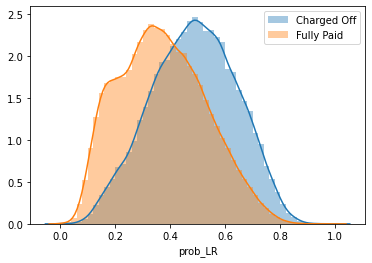

In [84]:
#Distribution of predicted probabilities from the LR model for each of the classes.
sns.distplot(testLoans[testLoans.charged_off==1].prob_LR, label='Charged Off').legend()
sns.distplot(testLoans[testLoans.charged_off==0].prob_LR, label='Fully Paid').legend()

In [85]:
#LR brier score - LR model.
brier_score_loss(testLoans.charged_off, testLoans.prob_LR)

0.18446149557051042

## Random Forest

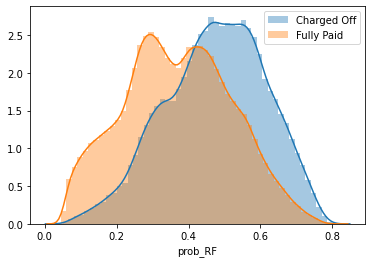

In [86]:
#Distribution of predicted probabilities from the LR model for each of the classes.
sns.distplot(testLoans[testLoans.charged_off==1].prob_RF, label='Charged Off').legend()
sns.distplot(testLoans[testLoans.charged_off==0].prob_RF, label='Fully Paid').legend()

In [87]:
#RF brier score - RF Model
brier_score_loss(testLoans.charged_off, testLoans.prob_RF)

0.1819317340333168

## Neural Net

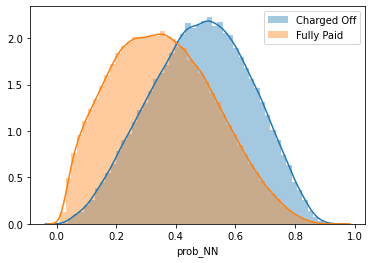

In [88]:
#Distribution of predicted probabilities from the LR model for each of the classes.
sns.distplot(testLoans[testLoans.charged_off==1].prob_NN, label='Charged Off').legend()
sns.distplot(testLoans[testLoans.charged_off==0].prob_NN, label='Fully Paid').legend()

In [89]:
#Neural net brier score - NN model
brier_score_loss(testLoans.charged_off, testLoans.prob_NN)

0.18119054450691893